In [ ]:
!pip install Hub && pip install wget

In [2]:
import tensorflow as tf
from hub import Dataset
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
print(tf.__version__)
# check if notebook is using GPU
tf.test.gpu_device_name()
import wget

2.4.0


## Load data

In [3]:
print("Load data from ActiveLoop ...")
tag = "margauxmforsythe/Senegal_histograms_weeks_19_30_Maize_IPAR_2017"
ds = Dataset(tag)

print("Dataset {} shape of histograms: {}".format(tag, ds["histograms"].compute()[0].shape))
image_count = ds["histograms"].compute().shape[0]
print("There are {} histograms in this dataset".format(image_count))

Load data from ActiveLoop ...
Dataset margauxmforsythe/Senegal_histograms_weeks_19_30_Maize_IPAR_2017 shape of histograms: (32, 11, 9)
There are 768 histograms in this dataset


Prepare data for CNN-LSTM model

In [4]:
histograms_ActiveLoop = ds["histograms"].compute()
histograms_CNN_LSTM = []
for i in range(image_count):
  histogram_all_timestamps_transposed = np.transpose(histograms_ActiveLoop[i], (1,0,2))
  timestamps = []
  for j in range(histograms_ActiveLoop[i].shape[1]): # going through all timestamps
    timestamps.append(np.expand_dims(histogram_all_timestamps_transposed[j], axis=0))
  histograms_CNN_LSTM.append(timestamps)
histograms = histograms_CNN_LSTM
input_shape_cnn = histograms[0][0].shape
print(input_shape_cnn)
input_shape_cnn_lstm = (len(histograms[0]),) + input_shape_cnn
print(input_shape_cnn_lstm)

(1, 32, 9)
(11, 1, 32, 9)


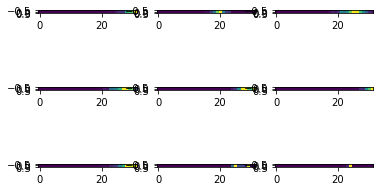

In [5]:
import matplotlib.pyplot as plt
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(histograms[0][0][:,:,i])

In [6]:
test_ds = tf.data.Dataset.from_tensor_slices(histograms)
test_ds = test_ds.batch(len(test_ds))
test_ds

<BatchDataset shapes: (None, 11, 1, 32, 9), types: tf.float64>

In [7]:
# TODO do with ActiveLoop?
uuids = np.load("./uuid_Maize_2017.npy")
uuids.shape

(768, 1)

## Model

In [8]:
# CNN-LSTM 
# https://www.mdpi.com/1424-8220/19/20/4363/htm
from keras.layers.wrappers import TimeDistributed
from keras.layers import *
from keras import regularizers
model=models.Sequential()

model.add(TimeDistributed(Conv2D(32, (1, 2), activation='relu',
                                  kernel_regularizer=regularizers.l2(0.001),
                                  input_shape=(input_shape_cnn)), input_shape=input_shape_cnn_lstm))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(1, 2))))

model.add(TimeDistributed(Conv2D(64, (1, 2), activation='relu',
                                  kernel_regularizer=regularizers.l2(0.001))))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(1, 2))))

model.add(TimeDistributed(Flatten()))
model.add(LSTM(256, return_sequences=True, activation='relu', dropout=0.25));

model.add(TimeDistributed(Dense(64)))
model.add(TimeDistributed(Flatten()))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(Dense(1)))
model.add(GlobalAveragePooling1D(name="global_avg_flow"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 11, 1, 31, 32)     608       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 11, 1, 31, 32)     128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 11, 1, 15, 32)     0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 11, 1, 14, 64)     4160      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 11, 1, 14, 64)     256       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 11, 1, 7, 64)      0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 11, 448)           0

In [9]:
initial_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy', tf.keras.metrics.RootMeanSquaredError(name='RMSE'), tf.keras.losses.MeanSquaredError(name='MSE')])

In [10]:
wget.download("https://omdena-gpsdd-senegal.s3-us-west-1.amazonaws.com/data/IPAR_data/pretrained_weights_CNN/checkpoint_b1_maize_best.h5", "./checkpoint.h5")

'./checkpoint (1).h5'

In [11]:
model.load_weights("./checkpoint.h5")

In [13]:
predictions = model.predict(test_ds)
i = 0
for prediction in predictions:
  print("prediction 2017 for uuid: {} is {}".format(uuids[i][0], prediction[0]))
  i = i + 1

prediction 2017 for uuid: 0003a9b4-9afb-4ff0-8efa-0fabbdb83ccb is 0.8194224834442139
prediction 2017 for uuid: 000be421-3444-486e-8d1c-23514be2cbde is 0.8120416402816772
prediction 2017 for uuid: 0139318c-52a7-4b72-9c73-374168f46200 is 1.1323908567428589
prediction 2017 for uuid: 016476e7-f902-4866-b9af-f78bb26b8e3d is 1.0421290397644043
prediction 2017 for uuid: 01b4707d-12bb-4b6b-9f63-14a49420eced is 1.143784761428833
prediction 2017 for uuid: 02717891-af80-4bed-9985-843f248d457e is 0.8281694054603577
prediction 2017 for uuid: 02af83d1-8d49-43e5-ba09-ebb17abd3dc4 is 0.2703569829463959
prediction 2017 for uuid: 02ba5955-d08b-4644-9097-8b311d546d02 is 0.5975127816200256
prediction 2017 for uuid: 02e6550d-ea21-4a21-9553-522cd15544ce is 0.7140056490898132
prediction 2017 for uuid: 030f9eea-dcba-4447-bdbd-7db1b2421d3e is 0.8827847838401794
prediction 2017 for uuid: 04db4c36-8660-44ad-8212-59d2fa46ee66 is 0.3654994070529938
prediction 2017 for uuid: 05d54f9c-9a72-4c92-879f-bd41f10f1ab9 is 